In [2]:
%pip install tensorflow_hub tensorflow matplotlib sklearn imblearn pandas
#libraries used : pandas, matplotlib.py, sklearn, tensorflow, tensorflow_hub, imblearn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.2.2 -> 22.3
[notice] To update, run: python.exe -m pip install --upgrade pip


objective: trying to predict the score of a review given a text review.
This machine learning model uses a dataset containing all sorts of amazon reviews.
This dataset consists of reviews of fine foods from amazon. The data span a period of more than 10 years, including all ~500,000 reviews up to October 2012. Reviews include product and user information (, ratings, and a plain text review. It also includes reviews from all other Amazon categories.

In [100]:
import pandas as pd

In [101]:
df = pd.read_csv("Reviews.csv")

In [102]:
#inspect a sample of the data
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [103]:
#drop unnecessary columns:
df.drop(["Id", "ProfileName", "UserId", "ProductId", "Summary","Time", "HelpfulnessNumerator", "HelpfulnessDenominator"], axis=1, inplace=True)

In [104]:
df.head()

,Score,Text
0,5,I have bought several of the Vitality canned d...
1,1,Product arrived labeled as Jumbo Salted Peanut...
2,4,This is a confection that has been around a fe...
3,2,If you are looking for the secret ingredient i...
4,5,Great taffy at a great price. There was a wid...


In [105]:
#look for missing values:
df.isnull().values.any()
df.isnull().sum().sum()

0

In [106]:

#There are 26 missing values. Not too many so we can just delete the rows that contain them.

df.dropna(inplace=True)


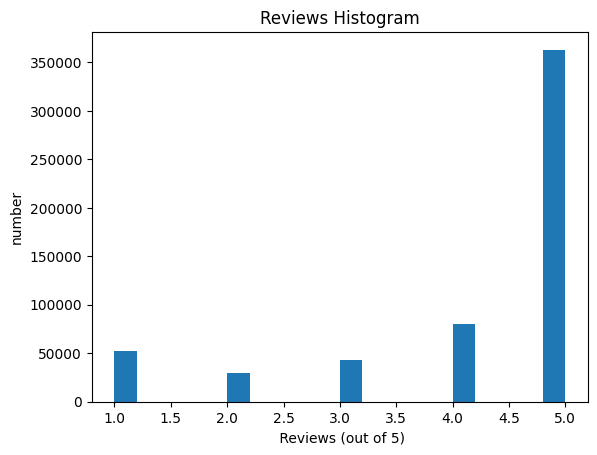

In [107]:
#plot a histogram to visualise the data (what the average review rating is)
import matplotlib.pyplot as plt

plt.hist(df.Score, bins=20)
plt.title("Reviews Histogram")
plt.ylabel("number")
plt.xlabel(" Reviews (out of 5)")
plt.show()

In [112]:
# too many 5 star reviews. Let's drop 20 percent of them:
#first sort df
df.sort_values('Score', ascending=True, inplace=True)
df = df[df['Score'].cumsum() / df['Score'].sum() < 0.7]

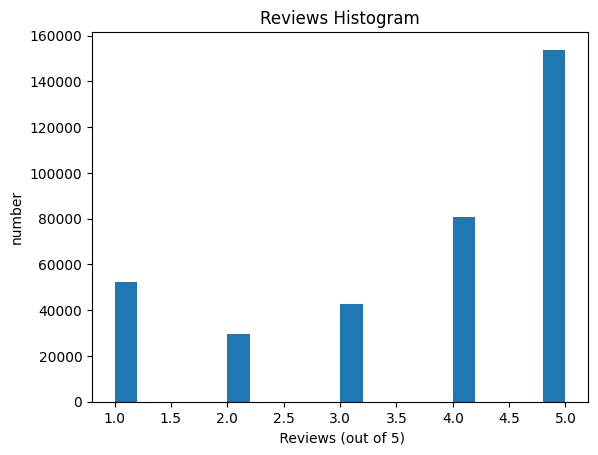

In [113]:
plt.hist(df.Score, bins=20)
plt.title("Reviews Histogram")
plt.ylabel("number")
plt.xlabel(" Reviews (out of 5)")
plt.show()

In [114]:
#can see that we have  a lot of positive reviews. Might have to oversample.
#creating a new model

df["good/bad review"] = (df.Score >= 4.0).astype(int)

df.head()

,Score,Text,good/bad review
445452,1,"I don't eat cereal, but I bought these for my ...",0
178288,1,It has been over three weeks and I still have ...,0
78861,1,"When I read the reviews for this product, I or...",0
178287,1,This tea tastes nasty. Maybe I just dont like...,0
78860,1,The so-called crabmeat is pure mush. I don't t...,0


In [115]:
df = df[["Text", "good/bad review"]]

In [116]:
df.head()

,Text,good/bad review
445452,"I don't eat cereal, but I bought these for my ...",0
178288,It has been over three weeks and I still have ...,0
78861,"When I read the reviews for this product, I or...",0
178287,This tea tastes nasty. Maybe I just dont like...,0
78860,The so-called crabmeat is pure mush. I don't t...,0


we have more positive reviews than negative ones. So let's resample

In [125]:
import numpy as np


In [126]:
#split data
train, val, test = np.split(df.sample(frac=1), [int(0.8*len(df)), int(0.9 * len(df))])

Using a pretrained embedding layer

tokenization: process of turning paragraphs into sentences, and sentences into words (so sentence is an arr of words (strings))

text vectorization: turning text to numbers

types of vectorization:
count vectorization
ngrams
TFIDF

In [119]:
import tensorflow_hub as hub
import tensorflow as tf

In [132]:
def df_to_dataset(data_df, shuffle=True, batch_size=10):
    df=data_df.copy()
    labels=df.pop("good/bad review")
    df = df["Text"]
    data_set = tf.data.Dataset.from_tensor_slices((df, labels))#create a tf data.dataset object with data and its labels
    if shuffle:
        data_set=data_set.shuffle(buffer_size=len(data_df))#shuffle data
    data_set = data_set.batch(batch_size) #split dataset into batches of 10 and repeat process for num of epochs
    data_set = data_set.prefetch(tf.data.AUTOTUNE)
    return data_set

In [133]:
train= df_to_dataset(train)
valid= df_to_dataset(val)
test= df_to_dataset(test)

In [135]:
list(train)[0]  #tensor object converted to a list

(<tf.Tensor: shape=(10,), dtype=string, numpy=
 array([b'We just bought this toy, and it is definetly something our dog loves and is interested in for a good period of time. It took her less than 20 minutes to figure out she just had to chew through the rope. If they could do a second version with a rope made of Kevlar or a metal chain with knots -that would be much better!',
        b"Why gamble with your dog's health? These are made in China.<br />Since Chinese manufacturers have proven that they don't care if they make Chinese children sick and die,<br />why would they care about American dogs??<br />I wouldn't have checked even ONE star but this review would not post<br />until I checked one.<br /><br />Check out Nature's Variety Brand products instead.",
        b"This wasn't as spicy as I would have liked and I was suprised to find that sugar was the second ingredient 6gms/serving). It's definitely a good snack food to use for a party mix but I would've liked more spice/saltiness

In [122]:
embedding = "https://tfhub.dev/google/nnlm-en-dim50/2"  #Token based text embedding trained on English Google News 7B corpus.
hub_layer = hub.KerasLayer(embedding, dtype=tf.string, trainable=True)


In [136]:
hub_layer(list(train)[0][0])

<tf.Tensor: shape=(10, 50), dtype=float32, numpy=
array([[ 5.85223675e-01, -8.07330832e-02, -6.83509037e-02,
         4.79992449e-01,  2.91544437e-01, -1.03346638e-01,
         1.37970433e-01,  1.47493798e-02, -7.01081932e-01,
         7.12039888e-01,  1.43396959e-01,  7.24401558e-03,
        -3.95369530e-01,  2.79892892e-01, -2.40519896e-01,
         1.19869173e-01, -1.27101585e-01,  1.95252791e-01,
         1.43850699e-01, -4.39573675e-01, -1.17716812e-01,
        -2.45792970e-01,  2.90360957e-01, -6.74513280e-02,
        -5.76518536e-01,  1.99503526e-01, -8.79817426e-01,
         3.91511545e-02,  1.67813569e-01, -1.55944780e-01,
        -1.30777806e-01,  4.13330615e-01,  3.71720612e-01,
        -4.67408858e-02, -1.12757042e-01,  5.14796793e-01,
         2.55026609e-01,  1.84504494e-01,  3.22209656e-01,
        -2.95138627e-01,  2.89472222e-01,  2.05410406e-01,
        -2.69298196e-01,  2.74046715e-02, -2.78790206e-01,
         1.14535071e-01, -3.48380953e-01, -2.43320420e-01,
      

In [134]:
encoder = tf.keras.layers.TextVectorization(max_tokens=2000)
encoder.adapt(train.map(lambda x, y: x))

In [99]:
#evaluating the model before training it
model.fit(X_train, y_train, batch_size=16, epochs=20, validation_data=(X_valid, y_valid))

Epoch 1/20


TypeError: in user code:

    File "c:\Users\amilc\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\amilc\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1146, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\amilc\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1135, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\amilc\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 994, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "c:\Users\amilc\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1052, in compute_loss
        return self.compiled_loss(
    File "c:\Users\amilc\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\compile_utils.py", line 265, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "c:\Users\amilc\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\losses.py", line 152, in __call__
        losses = call_fn(y_true, y_pred)
    File "c:\Users\amilc\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\losses.py", line 272, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "c:\Users\amilc\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\losses.py", line 2152, in binary_crossentropy
        label_smoothing = tf.convert_to_tensor(label_smoothing, dtype=y_pred.dtype)

    TypeError: Expected string, but got 0.0 of type 'float'.
